In [1]:
from math import pi
import math
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# import Qiskit
from qiskit import Aer,  execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

from qiskit.aqua.components.feature_maps.raw_feature_vector import RawFeatureVector


import warnings
import itertools
warnings.filterwarnings("ignore", category=DeprecationWarning) 
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_559350/1777384334.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [39]:
# UTILS FOR COMPUTING EFFICIENCIES
def makeitinteger(centers):
    intcenters=[int(centers[0])]
    for i in range(1,len(centers)):
        integer=int(centers[i])
        intcenters=np.append(intcenters,int(integer))
    return intcenters
def compute_efficiency(o_centers,intcenters):
    eff=0
    #intcenters=makeitinteger(centers)
    for i in range(len(intcenters)):
        if (o_centers[i]==intcenters[i]):
            eff+=1
    return (eff/len(intcenters))
def changing_index(a,b,intcenters):
    intcentersaux=np.where(intcenters==a, b,intcenters)
    intcenters=np.where(intcenters==b,a,intcentersaux)
    return intcenters
def final_efficiency(o_centers,centers,k):
    effmax=0
    intcenters=makeitinteger(centers)
    goodcenters=intcenters.copy()
    for i in range(0,k-1):
        for j in range(0,k):#1
            intcentersaux=changing_index(i,j,intcenters)
            
            eff=compute_efficiency(o_centers,intcentersaux)
            
            if(eff>effmax):
                effmax=eff
                goodcenters=intcentersaux
                intcenters=goodcenters
    return (effmax,goodcenters)
def final_efficiency_converged(o_centers,centers,k):
    intcenters=makeitinteger(centers)
    stop=0
    ef,intcenters=final_efficiency(o_centers,intcenters,k)# we are changing intcenters 
    while (stop==0):
        efprime,intcentersprime=final_efficiency(o_centers,intcenters,k)
        if (efprime==ef):
            stop=1
        else:
            ef=efprime
            intcenters=intcentersprime
    return (ef,intcenters)


In [20]:
# OBTAINING QUANTUM MINIMUM
def get_quantum_maximum(array):
    backend = Aer.get_backend('qasm_simulator') 
    X=np.array(array)
    fvc = RawFeatureVector(len(X))
    q1 = QuantumRegister(fvc.num_qubits)
    minimum_circuit = fvc.construct_circuit(X, qr=q1)
    minimum_circuit.measure_all()
    result = execute(minimum_circuit, backend, shots=100).result()
    counts=result.get_counts()
    max_value = max(counts.values())
    max_values_counts = [x[0] for x in counts.items() if x[1] == max_value]
    #result=counts.most_frequent()
    result=max_values_counts[0]
    index_minimum=int(result,2)
    return index_minimum
def get_quantum_minimum(array):
    array_power=np.array(array)**1
    array_inv=1/array_power
    index_min=get_quantum_maximum(array_inv)
    return index_min

In [4]:
# PROCESS AND TRANSFORMATION OF DATA

def process_together(points):
    maximum=points.max()
    minimum=points.min()
    points_std=(points-minimum)/(maximum-minimum)
    points_scaled=points_std*(10-1)+1
    return (points_scaled,maximum,minimum)

def transform_all_to_angular_4(data_momentum_vector):
    data_angular_vector=data_momentum_vector.copy()
    for i in range(len(data_momentum_vector)):
        data_angular_vector[i]=transform_to_angular_4(data_momentum_vector[i])
    
    return(data_angular_vector)
    
def transform_to_angular_4(data_momentum):
    data_angular=data_momentum.copy()
    data_angular[0]=(data_momentum[0]**2+data_momentum[1]**2)**0.5
    data_angular[1]=0.5*np.log(abs((data_momentum[3]+data_momentum[2])/
                            (data_momentum[3]-data_momentum[2])))#abs
    data_angular[2]=math.atan(data_momentum[1]/data_momentum[0])
    if(data_momentum[0]<0):
        data_angular[2]+=pi
    data_angular[3]=(data_momentum[3]**2-data_momentum[2]**2)**0.5#m_T
    #data_angular[2]+=2*pi
    return(data_angular)

def transform_all_to_momentum_4(data_angular_vector):
    data_momentum_vector=data_angular_vector.copy()
    for i in range(len(data_momentum_vector)):
        data_momentum_vector[i]=transform_to_momentum_4(data_angular_vector[i])
    return(data_momentum_vector)
def transform_to_momentum_4(data_angular):
    data_momentum=data_angular.copy()
    data_momentum[0]=data_angular[0]*math.cos(data_angular[2])
    data_momentum[1]=data_angular[0]*math.sin(data_angular[2])
    data_momentum[2]=data_angular[3]*math.sinh(data_angular[1])
    data_momentum[3]=data_angular[3]*math.cosh(data_angular[1])
    return data_momentum

In [5]:
# FUNCTIONS TO FIND THE MINIMUM AMONG THE DISTANCES
def find_minimum_cut(data,a,R,ptmin):
    #data_aux=data.copy()
    rapidity_plus_phi=data[:,1:3]
    rapidity_plus_phi_processed,max_processed,min_processed=process_together(rapidity_plus_phi)
    #print(rapidity_plus_phi_processed)
    min_dis=10**10
    lista=[]
    for i in range(len(data)):
        piB=data[i,0]**a
        min_dis_j=10**10
        #print("piB",i,piB)
        #lista.append([piB,i,len(data)+5])
        for j in range(i+1,len(data)):
            pij=kt_distance(data[i],data[j],rapidity_plus_phi_processed[i],
                                rapidity_plus_phi_processed[j],max_processed,min_processed,
                                a,R)
                #print("pij",i,j,pij)
            #lista.append([pij,i,j])
            if(pij<min_dis_j):
                min_dis_j=pij
                jlgood=j
        if(min_dis_j<piB or data[i,0]<ptmin):
            if(min_dis_j<min_dis):
                min_dis=min_dis_j
                igood=i
                jgood=jlgood
        else:
            if(piB<=min_dis ):
                min_dis=piB
                igood=i
                jgood=len(data)+5#the minimum distance is wrt to the beam
    #print(lista)
    return(min_dis,igood,jgood)

def find_minimumN2_quantum_cut(data,a,R,ptcut):
    rapidity_plus_phi=data[:,1:3]
    rapidity_plus_phi_processed,max_processed,min_processed=process_together(rapidity_plus_phi)
    lista=[]
    
    for i in range(len(data)):
        piB=data[i,0]**a
        if (data[i,0]>ptcut):
            lista.append([piB,i,len(data)+5])
        else:
            if(len(data)==2):
                lista.append([piB+999999999999,i,len(data)+5])
        listaj=[]
        for j in range(i+1,len(data)):
            pij=kt_distance(data[i],data[j],rapidity_plus_phi_processed[i],
                                rapidity_plus_phi_processed[j],max_processed,min_processed,
                                a,R)
            listaj.append([pij,i,j])
            
        arrayj=np.array(listaj)
        if(len(arrayj)>1):
            indexj=get_quantum_minimum(arrayj[:,0])
            min_disj=arrayj[indexj,0]
            igoodj=int(arrayj[indexj,1])
            jgoodj=int(arrayj[indexj,2])
            lista.append([min_disj,igoodj,jgoodj])
        else:
            if(len(arrayj)==1):
                indexj=0
                min_disj=arrayj[indexj,0]
                igoodj=int(arrayj[indexj,1])
                jgoodj=int(arrayj[indexj,2])
                lista.append([min_disj,igoodj,jgoodj])
    array=np.array(lista)
    index=get_quantum_minimum(array[:,0])
    min_dis=array[index,0]
    igood=int(array[index,1])
    jgood=int(array[index,2])
    #print(lista)
    return(min_dis,igood,jgood)

In [6]:
# FUNCTIONS FOR RUNNING KT ALGORITHM

def kt_distance(p1_angular,p2_angular,rapidity_plus_phi1,
                                    rapidity_plus_phi2,max_processed,min_processed,a,R):

    deltaR2=deltaR2_classical(p1_angular[1:3],p2_angular[1:3])
    
    min_pts=min(p1_angular[0]**a,p2_angular[0]**a)
    dij=min_pts*deltaR2/(R**2)
    return dij
def deltaR2_classical(p1_angles,p2_angles):
    return((p1_angles[0]-p2_angles[0])**2+(p1_angles[1]-p2_angles[1])**2)



def merge_or_remove(indexes,indexes_jets,final_jets,data_angular,data_momentum,a,R,qsearch,ptcut):

    if(qsearch):
        min_dis,i,j=find_minimumN2_quantum_cut(data_angular,a,R,ptcut)#quantum
    else:
        min_dis,i,j=find_minimum_cut(data_angular,a,R,ptcut)
    

    final_jets_copy=final_jets.copy()
    if(j==(len(data_angular)+5)):
        #print("remove:",i,min_dis,data_angular[i,0])
        indexes_jets,indexes,final_jets_copy,data_angular,data_momentum=remove(indexes,indexes_jets,final_jets_copy,data_angular,data_momentum,i)
        #print(indexes_jets)
    else:
        #print("merge:",i,j,min_dis)
        indexes,data_angular,data_momentum=merge(indexes,data_angular,data_momentum,i,j)
    return(final_jets_copy,data_angular,data_momentum,min_dis,indexes,indexes_jets)
def remove(indexes,indexes_jets,final_jets,data_angular,data_momentum,i):
    if (len(final_jets)==0):
        final_jets=[data_angular[i]]
    else:
        final_jets=np.concatenate((final_jets,[data_angular[i]]),0)
    indexes_jets.append(indexes[i])
    indexes_jets[len(indexes_jets)-1]=list(itertools.chain(*indexes_jets[len(indexes_jets)-1]))
    indexes.pop(i)
    return(indexes_jets,indexes,final_jets,np.delete(data_angular,i,0),np.delete(data_momentum,i,0))
def merge(indexes,data_angular,data_momentum,i,j):
    
    data_momentum[i]=data_momentum[i]+data_momentum[j]
    data_angular[i]=transform_to_angular_4(data_momentum[i])#we introduce the 4
    data_angular=np.delete(data_angular,j,0)
    data_momentum=np.delete(data_momentum,j,0)
    indexes[i].append(list(itertools.chain(*indexes[j])))
    indexes.pop(j)
    return(indexes,data_angular,data_momentum)



In [ ]:
# ANTIKT, KT AND CAM/AACHEN ALGORITHM
def run_kt_inclusive(data_angular,data_momentum,a,R,qsearch,ptcut):
    data_angular_copy=data_angular.copy()
    data_momentum_copy=data_momentum.copy()
    final_jets=[]
    indexes_jets=[]
    
    indexes=[]
    for i in range(len(data_angular)):
        indexes.append([[i]])
    while (len(data_momentum_copy)>1):
        final_jets,data_angular_copy,data_momentum_copy,min_dis,indexes,indexes_jets=merge_or_remove(indexes,indexes_jets,final_jets,data_angular_copy,
                                                                        data_momentum_copy,a,R,qsearch,ptcut)
        
    a,b,final_jets,data_angular_copy,data_momentum_copy=remove(indexes,indexes_jets,final_jets,data_angular_copy,data_momentum_copy,0)
    #final_jets,indexes_jets=merge_or_remove_last(indexes,indexes_jets,final_jets,data_angular_copy,data_momentum_copy,a,R,quantum,ptcut)
    #for i in range(len(indexes_jets)):
    #    indexes_jets[i]=list(itertools.chain(*indexes_jets[i]))
    return(final_jets,data_angular_copy,data_momentum_copy,indexes_jets,indexes) 

In [8]:
points=np.loadtxt('realdata.txt')

In [9]:
#REAL DATA
a=-2
R=1
points_energy=points
points_angular=transform_all_to_angular_4(points_energy)
#CLASSIC
jets_minus2_classical7c=run_kt_inclusive(points_angular,points_energy,a,R,0,10)
final_jets_mom_minus2_7c=transform_all_to_momentum_4(jets_minus2_classical7c[0])
print(final_jets_mom_minus2_7c)
print(jets_minus2_classical7c[3])
print(jets_minus2_classical7c[4])
lista_minus2_7c=list(np.arange(len(points)))
sol_minus2_7c=jets_minus2_classical7c[3]
#print(sol[1].index(13))
for i in range(len(final_jets_mom_minus2_7c)):
    for j in range(len(sol_minus2_7c[i])):
        lista_minus2_7c[sol_minus2_7c[i][j]]=i
centers_minus2_7c = np.array(lista_minus2_7c)    
print(lista_minus2_7c)

[[ 2.19992939e+03 -1.68615606e+03 -8.33079921e+02  3.06444599e+03]
 [-2.17793026e+02  1.88302828e+03  7.93104501e+02  2.06972789e+03]
 [-1.28512391e+03  1.09604373e+03 -5.62865448e+02  1.80766768e+03]
 [-1.04895115e+03 -1.18000047e+03  4.69620098e+02  1.74021703e+03]
 [ 3.00013024e+02  1.81561747e+02  1.30333646e+03  1.34973458e+03]
 [-1.24095000e+01 -2.50566000e+02 -4.62284000e+02  5.25969000e+02]
 [ 9.16626400e+01 -4.49869250e+01  1.18392080e+02  1.64419730e+02]
 [-1.37312088e+01  1.04646556e+01  2.90505504e+01  3.38128938e+01]
 [-1.40954107e+01 -8.91624823e+00 -1.37450235e+01  2.16126767e+01]
 [ 5.04122410e-01 -4.71841450e-01 -1.52964210e+00  2.38998650e+00]]
[[3, 13, 33, 40, 42, 47, 55, 38, 30, 18, 58, 61, 52, 5, 34, 45, 36, 57, 62, 21, 6, 49], [9, 25, 96, 97, 112, 119, 120, 115, 127, 98, 101, 125, 117, 104, 122, 102, 107, 109, 111, 116, 103, 99, 100, 108, 110, 106, 124, 118, 105, 126, 123, 121, 114, 113, 53, 35], [7, 17, 64, 65, 66, 68, 71, 94, 78, 92, 88, 77, 86, 85, 90, 72, 75, 

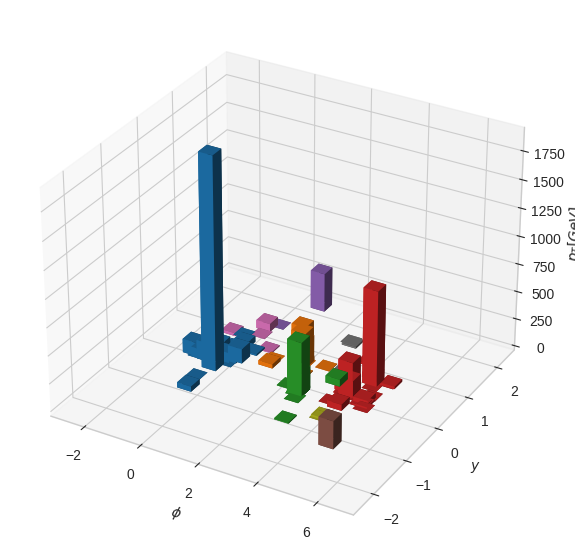

In [10]:
points_cluster0=points_angular[centers_minus2_7c==0]
points_cluster1=points_angular[centers_minus2_7c==1]
points_cluster2=points_angular[centers_minus2_7c==2]
points_cluster3=points_angular[centers_minus2_7c==3]
points_cluster4=points_angular[centers_minus2_7c==4]
points_cluster5=points_angular[centers_minus2_7c==5]
points_cluster6=points_angular[centers_minus2_7c==6]
points_cluster7=points_angular[centers_minus2_7c==7]
points_cluster8=points_angular[centers_minus2_7c==8]

fig = plt.figure(figsize=(7,7))
#fig = plt.figure()
ax1 = fig.add_subplot( projection='3d')
ax1.set_ylabel('$y$')
ax1.set_xlabel('$\phi$')
ax1.set_zlabel('$p_T [GeV]$')
ax1.set_ylim([-2.5, 2.5])
ax1.set_xlim([-3, 7])
width =0.5
depth = 0.25
#blue
ax1.bar3d(points_cluster0[:,2], points_cluster0[:,1], np.zeros_like(points_cluster0[:,1]), width, depth, points_cluster0[:,0],shade=True)
#orange
ax1.bar3d(points_cluster1[:,2], points_cluster1[:,1], np.zeros_like(points_cluster1[:,1]), width, depth, points_cluster1[:,0],shade=True)
#green
ax1.bar3d(points_cluster2[:,2], points_cluster2[:,1], np.zeros_like(points_cluster2[:,1]), width, depth, points_cluster2[:,0],shade=True)
#red
ax1.bar3d(points_cluster3[:,2], points_cluster3[:,1], np.zeros_like(points_cluster3[:,1]), width, depth, points_cluster3[:,0],shade=True)
#purple
ax1.bar3d(points_cluster4[:,2], points_cluster4[:,1], np.zeros_like(points_cluster4[:,1]), width, depth, points_cluster4[:,0],shade=True)
#brown
ax1.bar3d(points_cluster5[:,2], points_cluster5[:,1], np.zeros_like(points_cluster5[:,1]), width, depth, points_cluster5[:,0],shade=True)
#pink
ax1.bar3d(points_cluster6[:,2], points_cluster6[:,1], np.zeros_like(points_cluster6[:,1]), width, depth, points_cluster6[:,0],shade=True)
#grey
ax1.bar3d(points_cluster7[:,2], points_cluster7[:,1], np.zeros_like(points_cluster7[:,1]), width, depth, points_cluster7[:,0],shade=True)
#ocher (behind green)
ax1.bar3d(points_cluster8[:,2], points_cluster8[:,1], np.zeros_like(points_cluster8[:,1]), width, depth, points_cluster8[:,0],shade=True)

#fig.add_axes(ax)
#ax1.set_title("Classical $anti-k_T$, a=-1, R=1")
plt.show()

#saving the plot
image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'classic_anti-kt_nt2.pdf'
fig.savefig(image_name, format=image_format, dpi=500)

In [11]:
#REAL DATA
a=2
R=1
points_energy=points
points_angular=transform_all_to_angular_4(points_energy)
#CLASSIC
jets_2_classical7c=run_kt_inclusive(points_angular,points_energy,a,R,0,10)
final_jets_mom_2_7c=transform_all_to_momentum_4(jets_2_classical7c[0])
print(final_jets_mom_2_7c)
print(jets_2_classical7c[3])
print(jets_2_classical7c[4])
lista_2_7c=list(np.arange(len(points)))
sol_2_7c=jets_2_classical7c[3]
#print(sol[1].index(13))
for i in range(len(final_jets_mom_2_7c)):
    for j in range(len(sol_2_7c[i])):
        lista_2_7c[sol_2_7c[i][j]]=i
centers_2_7c = np.array(lista_2_7c)    
print(lista_2_7c)

[[  -13.6756        10.45633       29.01689       33.74736   ]
 [  -12.41272989  -250.57041575  -462.3218471    526.0072405 ]
 [  299.683        181.572       1302.83        1349.13      ]
 [-1126.28602807 -1189.38086138   468.21756461  1826.4135476 ]
 [-1222.03871018  1096.46384405  -574.90284837  1743.4428843 ]
 [ -217.5142311   1883.238408     792.6281157   2070.3185    ]
 [ 2292.2492682  -1731.7784397   -715.4682245   3230.937918  ]]
[[41, 43], [1, 22], [32], [0, 23, 59, 10, 27, 8, 28, 63, 16, 24, 2, 12, 31, 4, 19, 20, 11, 26, 14, 7, 29, 39, 46], [17, 64, 73, 81, 67, 74, 68, 85, 78, 92, 94, 71, 88, 77, 90, 86, 82, 37, 60, 69, 84, 79, 95, 76, 91, 87, 70, 65, 72, 80, 66, 75, 89, 83, 93], [9, 25, 96, 113, 99, 100, 118, 107, 103, 116, 126, 109, 111, 125, 114, 121, 104, 122, 97, 119, 112, 102, 115, 127, 120, 98, 101, 106, 105, 123, 108, 117, 110, 124, 35, 53, 48], [3, 13, 5, 18, 45, 15, 49, 21, 34, 52, 6, 30, 38, 47, 40, 42, 36, 61, 44, 62, 58, 50, 54, 56, 33, 51, 55, 57]]
[]
[3, 1, 3, 

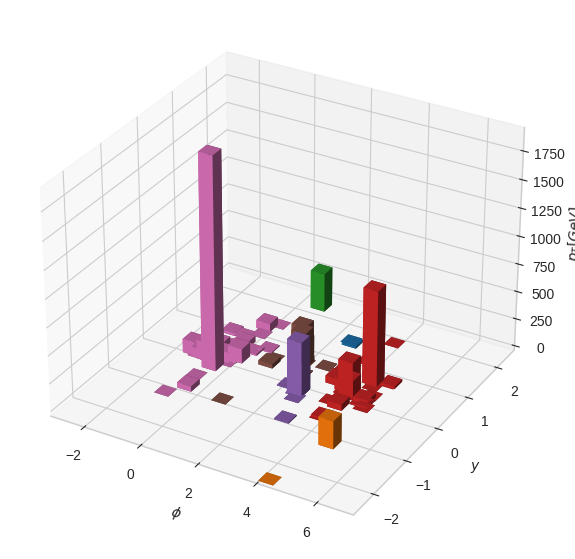

In [12]:
points_cluster0=points_angular[centers_2_7c==0]
points_cluster1=points_angular[centers_2_7c==1]
points_cluster2=points_angular[centers_2_7c==2]
points_cluster3=points_angular[centers_2_7c==3]
points_cluster4=points_angular[centers_2_7c==4]
points_cluster5=points_angular[centers_2_7c==5]
points_cluster6=points_angular[centers_2_7c==6]
points_cluster7=points_angular[centers_2_7c==7]
points_cluster8=points_angular[centers_2_7c==8]

fig = plt.figure(figsize=(7,7))
#fig = plt.figure()
ax1 = fig.add_subplot( projection='3d')
ax1.set_ylabel('$y$')
ax1.set_xlabel('$\phi$')
ax1.set_zlabel('$p_T [GeV]$')
ax1.set_ylim([-2.5, 2.5])
ax1.set_xlim([-3, 7])
width =0.5
depth = 0.25
#blue
ax1.bar3d(points_cluster0[:,2], points_cluster0[:,1], np.zeros_like(points_cluster0[:,1]), width, depth, points_cluster0[:,0],shade=True)
#orange
ax1.bar3d(points_cluster1[:,2], points_cluster1[:,1], np.zeros_like(points_cluster1[:,1]), width, depth, points_cluster1[:,0],shade=True)
#green
ax1.bar3d(points_cluster2[:,2], points_cluster2[:,1], np.zeros_like(points_cluster2[:,1]), width, depth, points_cluster2[:,0],shade=True)
#red
ax1.bar3d(points_cluster3[:,2], points_cluster3[:,1], np.zeros_like(points_cluster3[:,1]), width, depth, points_cluster3[:,0],shade=True)
#purple
ax1.bar3d(points_cluster4[:,2], points_cluster4[:,1], np.zeros_like(points_cluster4[:,1]), width, depth, points_cluster4[:,0],shade=True)
#brown
ax1.bar3d(points_cluster5[:,2], points_cluster5[:,1], np.zeros_like(points_cluster5[:,1]), width, depth, points_cluster5[:,0],shade=True)
#pink
ax1.bar3d(points_cluster6[:,2], points_cluster6[:,1], np.zeros_like(points_cluster6[:,1]), width, depth, points_cluster6[:,0],shade=True)
#grey
#ax1.bar3d(points_cluster7[:,2], points_cluster7[:,1], np.zeros_like(points_cluster7[:,1]), width, depth, points_cluster7[:,0],shade=True)
#ocher (behind green)
#ax1.bar3d(points_cluster8[:,2], points_cluster8[:,1], np.zeros_like(points_cluster8[:,1]), width, depth, points_cluster8[:,0],shade=True)


#fig.add_axes(ax)
#ax1.set_title("Classical $k_T$, a=1, R=1")
plt.show()

#saving the plot
image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'classic_kt_nt2.pdf'
fig.savefig(image_name, format=image_format, dpi=500)


    #print(centers)# find centroids

In [13]:
#REAL DATA
a=0
R=1
points_energy=points
points_angular=transform_all_to_angular_4(points_energy)
#CLASSIC
jets_0_classical7c=run_kt_inclusive(points_angular,points_energy,a,R,0,10)
final_jets_mom_0_7c=transform_all_to_momentum_4(jets_0_classical7c[0])
#final_jets_mom_0_7c=final_jets_mom_0_7c[np.argsort(final_jets_mom_0_7c[:, 3])][::-1]#sort the array and it reverses it
print(final_jets_mom_0_7c)
print(jets_0_classical7c[3])
print(jets_0_classical7c[4])
lista_0_7c=list(np.arange(len(points)))
sol_0_7c=jets_0_classical7c[3]
#print(sol[1].index(13))
for i in range(len(final_jets_mom_0_7c)):
    for j in range(len(sol_0_7c[i])):
        lista_0_7c[sol_0_7c[i][j]]=i
centers_0_7c = np.array(lista_0_7c)    
print(lista_0_7c)

[[-1.36756000e+01  1.04563300e+01  2.90168900e+01  3.37473600e+01]
 [ 4.86045730e+01  3.21800500e+01  1.47023430e+01  6.41410850e+01]
 [ 2.99683000e+02  1.81572000e+02  1.30283000e+03  1.34913000e+03]
 [-1.22515088e+03  1.10326631e+03 -5.74002952e+02  1.75097740e+03]
 [ 8.41301710e+01 -4.90765437e+01  1.14809200e+02  1.55864142e+02]
 [-2.40102569e+02  1.84799140e+03  7.87196752e+02  2.02386088e+03]
 [ 2.18493624e+03 -1.68664754e+03 -8.39971914e+02  3.04926518e+03]
 [-1.24095000e+01 -2.50566000e+02 -4.62284000e+02  5.25969000e+02]
 [-1.12628603e+03 -1.18938086e+03  4.68217565e+02  1.82641355e+03]
 [ 2.75565110e-01  2.05717250e-01 -5.14232100e-01  6.28854500e-01]]
[[41, 43], [35, 53, 44, 62], [32], [17, 64, 65, 72, 80, 66, 75, 83, 93, 68, 85, 78, 94, 92, 71, 88, 77, 86, 90, 69, 84, 79, 95, 70, 89, 73, 81, 82, 74, 76, 87, 91, 67, 25, 60, 37], [15, 49, 50, 56, 54], [9, 96, 97, 112, 119, 115, 120, 127, 98, 101, 103, 116, 104, 122, 109, 111, 125, 99, 100, 107, 118, 102, 108, 117, 110, 124, 1

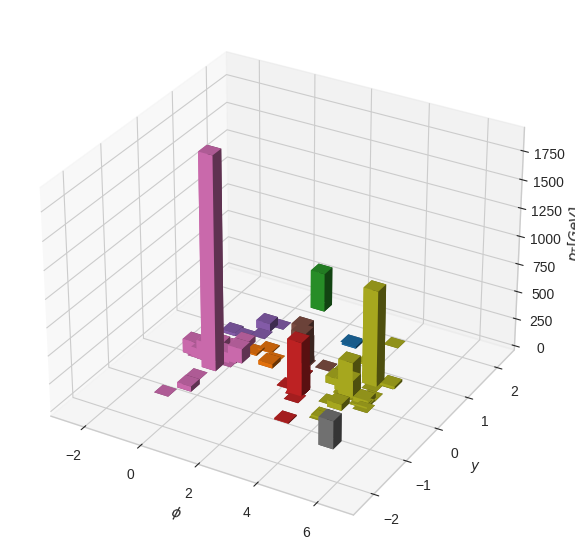

In [14]:
points_cluster0=points_angular[centers_0_7c==0]
points_cluster1=points_angular[centers_0_7c==1]
points_cluster2=points_angular[centers_0_7c==2]
points_cluster3=points_angular[centers_0_7c==3]
points_cluster4=points_angular[centers_0_7c==4]
points_cluster5=points_angular[centers_0_7c==5]
points_cluster6=points_angular[centers_0_7c==6]
points_cluster7=points_angular[centers_0_7c==7]
points_cluster8=points_angular[centers_0_7c==8]

fig = plt.figure(figsize=(7,7))
#fig = plt.figure()
ax1 = fig.add_subplot( projection='3d')
ax1.set_ylabel('$y$')
ax1.set_xlabel('$\phi$')
ax1.set_zlabel('$p_T [GeV]$')
ax1.set_ylim([-2.5, 2.5])
ax1.set_xlim([-3, 7])
width =0.5
depth = 0.25
#blue
ax1.bar3d(points_cluster0[:,2], points_cluster0[:,1], np.zeros_like(points_cluster0[:,1]), width, depth, points_cluster0[:,0],shade=True)
#orange
ax1.bar3d(points_cluster1[:,2], points_cluster1[:,1], np.zeros_like(points_cluster1[:,1]), width, depth, points_cluster1[:,0],shade=True)
#green
ax1.bar3d(points_cluster2[:,2], points_cluster2[:,1], np.zeros_like(points_cluster2[:,1]), width, depth, points_cluster2[:,0],shade=True)
#red
ax1.bar3d(points_cluster3[:,2], points_cluster3[:,1], np.zeros_like(points_cluster3[:,1]), width, depth, points_cluster3[:,0],shade=True)
#purple
ax1.bar3d(points_cluster4[:,2], points_cluster4[:,1], np.zeros_like(points_cluster4[:,1]), width, depth, points_cluster4[:,0],shade=True)
#brown
ax1.bar3d(points_cluster5[:,2], points_cluster5[:,1], np.zeros_like(points_cluster5[:,1]), width, depth, points_cluster5[:,0],shade=True)
#pink
ax1.bar3d(points_cluster6[:,2], points_cluster6[:,1], np.zeros_like(points_cluster6[:,1]), width, depth, points_cluster6[:,0],shade=True)
#grey
ax1.bar3d(points_cluster7[:,2], points_cluster7[:,1], np.zeros_like(points_cluster7[:,1]), width, depth, points_cluster7[:,0],shade=True)
#ocher (behind green)
ax1.bar3d(points_cluster8[:,2], points_cluster8[:,1], np.zeros_like(points_cluster8[:,1]), width, depth, points_cluster8[:,0],shade=True)

#fig.add_axes(ax)
#ax1.set_title("Classical $anti-k_T$, a=-1, R=1")
plt.show()

#saving the plot
image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'classic_cam_nt2.pdf'
fig.savefig(image_name, format=image_format, dpi=500)

In [21]:
#REAL DATA
a=-2
R=1
points_energy=points
points_angular=transform_all_to_angular_4(points_energy)
#QUANTUM
qsearch=True
jets_minus2_quantum100q=run_kt_inclusive(points_angular,points_energy,a,R,qsearch,10)

final_jets_mom_minus2_100q=transform_all_to_momentum_4(jets_minus2_quantum100q[0])
print(final_jets_mom_minus2_100q)
print(jets_minus2_quantum100q[3])

lista_minus2_100q=list(np.arange(len(points)))
sol_minus2_100q=jets_minus2_quantum100q[3]
#print(sol[1].index(13))
for i in range(len(final_jets_mom_minus2_100q)):
    for j in range(len(sol_minus2_100q[i])):
        lista_minus2_100q[sol_minus2_100q[i][j]]=i
centers_minus2_100q = np.array(lista_minus2_100q)    
print(lista_minus2_100q)

[[ 2.19992939e+03 -1.68615606e+03 -8.33079921e+02  3.06444599e+03]
 [-2.17793026e+02  1.88302828e+03  7.93104501e+02  2.06972789e+03]
 [-1.28512391e+03  1.09604373e+03 -5.62865448e+02  1.80766768e+03]
 [-1.04895115e+03 -1.18000047e+03  4.69620098e+02  1.74021703e+03]
 [ 2.99683000e+02  1.81572000e+02  1.30283000e+03  1.34913000e+03]
 [-1.24095000e+01 -2.50566000e+02 -4.62284000e+02  5.25969000e+02]
 [ 9.19926640e+01 -4.49971777e+01  1.18898537e+02  1.65024312e+02]
 [-1.37312088e+01  1.04646556e+01  2.90505504e+01  3.38128938e+01]
 [-1.40954107e+01 -8.91624823e+00 -1.37450235e+01  2.16126767e+01]
 [ 5.04122410e-01 -4.71841450e-01 -1.52964210e+00  2.38998650e+00]]
[[3, 13, 33, 40, 42, 47, 55, 38, 30, 18, 61, 58, 52, 5, 34, 45, 36, 57, 62, 21, 6, 49], [9, 25, 96, 97, 112, 119, 120, 115, 127, 98, 101, 125, 117, 104, 122, 102, 107, 109, 111, 116, 103, 99, 100, 108, 110, 106, 124, 118, 105, 126, 123, 121, 114, 113, 53, 35], [7, 17, 64, 65, 66, 68, 71, 94, 78, 92, 88, 77, 86, 85, 90, 72, 75, 

In [28]:

centers_minus2_100q = np.array(lista_minus2_100q)  
centers_minus2_7q_changed=change_labels(final_jets_mom_minus2_100q,final_jets_mom_minus2_7c,centers_minus2_100q)
#eff_kt=compute_effs_anti(centers_2_7c,centers_2_7q_changed)
#eff_antikt=compute_effs_anti(centers_minus2_7c,centers_minus2_100q)
eff_antikt=compute_effs_anti(centers_minus2_7c,centers_minus2_7q_changed)
print(eff_antikt)
eff_qkt,centers_minus2_100q_2=final_efficiency_converged(centers_minus2_100q,centers_minus2_7c,
                                                         max(centers_minus2_100q)+1)
print(centers_minus2_100q_2)
print(centers_minus2_100q)
print(centers_minus2_7c)
print(eff_qkt)

0.9921875
[3 5 3 0 3 0 0 2 3 1 3 8 3 0 3 6 3 2 0 3 3 0 9 3 3 1 8 3 3 7 0 3 4 0 0 1 0
 2 0 3 0 7 0 7 6 0 9 0 9 0 6 9 0 1 4 0 6 0 0 3 2 0 0 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[3 5 3 0 3 0 0 2 3 1 3 8 3 0 3 6 3 2 0 3 3 0 9 3 3 1 8 3 3 7 0 3 4 0 0 1 0
 2 0 3 0 7 0 7 6 0 9 0 9 0 6 9 0 1 6 0 6 0 0 3 2 0 0 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[3 5 3 0 3 0 0 2 3 1 3 8 3 0 3 6 3 2 0 3 3 0 9 3 3 1 8 3 3 7 0 3 4 0 0 1 0
 2 0 3 0 7 0 7 6 0 9 0 9 0 6 9 0 1 4 0 6 0 0 3 2 0 0 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.9921875


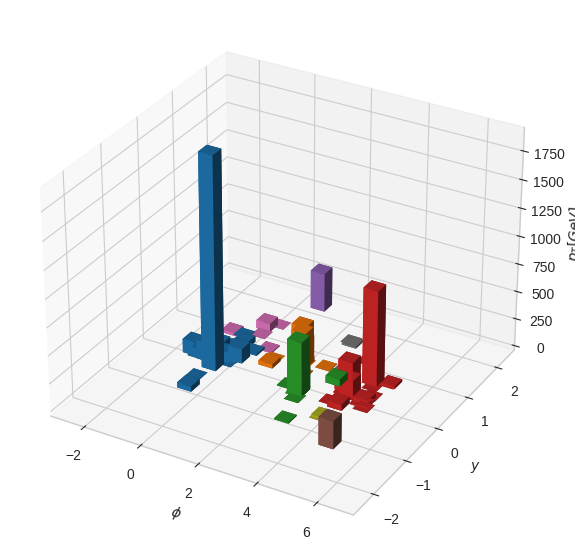

In [23]:
points_cluster0=points_angular[centers_minus2_100q_2==0]
points_cluster1=points_angular[centers_minus2_100q_2==1]
points_cluster2=points_angular[centers_minus2_100q_2==2]
points_cluster3=points_angular[centers_minus2_100q_2==3]
points_cluster4=points_angular[centers_minus2_100q_2==4]
points_cluster5=points_angular[centers_minus2_100q_2==5]
points_cluster6=points_angular[centers_minus2_100q_2==6]
points_cluster7=points_angular[centers_minus2_100q_2==7]
points_cluster8=points_angular[centers_minus2_100q_2==8]

fig = plt.figure(figsize=(7,7))
#fig = plt.figure()
ax1 = fig.add_subplot( projection='3d')
ax1.set_ylabel('$y$')
ax1.set_xlabel('$\phi$')
ax1.set_zlabel('$p_T [GeV]$')
ax1.set_ylim([-2.5, 2.5])
ax1.set_xlim([-3, 7])
width =0.5
depth = 0.25
#blue
ax1.bar3d(points_cluster0[:,2], points_cluster0[:,1], np.zeros_like(points_cluster0[:,1]), width, depth, points_cluster0[:,0],shade=True)
#orange
ax1.bar3d(points_cluster1[:,2], points_cluster1[:,1], np.zeros_like(points_cluster1[:,1]), width, depth, points_cluster1[:,0],shade=True)
#green
ax1.bar3d(points_cluster2[:,2], points_cluster2[:,1], np.zeros_like(points_cluster2[:,1]), width, depth, points_cluster2[:,0],shade=True)
#red
ax1.bar3d(points_cluster3[:,2], points_cluster3[:,1], np.zeros_like(points_cluster3[:,1]), width, depth, points_cluster3[:,0],shade=True)
#purple
ax1.bar3d(points_cluster4[:,2], points_cluster4[:,1], np.zeros_like(points_cluster4[:,1]), width, depth, points_cluster4[:,0],shade=True)
#brown
ax1.bar3d(points_cluster5[:,2], points_cluster5[:,1], np.zeros_like(points_cluster5[:,1]), width, depth, points_cluster5[:,0],shade=True)
#pink
ax1.bar3d(points_cluster6[:,2], points_cluster6[:,1], np.zeros_like(points_cluster6[:,1]), width, depth, points_cluster6[:,0],shade=True)
#grey
ax1.bar3d(points_cluster7[:,2], points_cluster7[:,1], np.zeros_like(points_cluster7[:,1]), width, depth, points_cluster7[:,0],shade=True)
#ocher (behind green)
ax1.bar3d(points_cluster8[:,2], points_cluster8[:,1], np.zeros_like(points_cluster8[:,1]), width, depth, points_cluster8[:,0],shade=True)

#fig.add_axes(ax)
#ax1.set_title("Classical $anti-k_T$, a=-1, R=1")
plt.show()

#saving the plot
image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'quantum_anti-kt_nt2.pdf'
fig.savefig(image_name, format=image_format, dpi=500)

In [29]:
#REAL DATA
a=2
R=1
points_energy=points
points_angular=transform_all_to_angular_4(points_energy)
#QUANTUM
qsearch=True
jets_2_quantum7q=run_kt_inclusive(points_angular,points_energy,a,R,qsearch,10)
final_jets_mom_2_7q=transform_all_to_momentum_4(jets_2_quantum7q[0])
print(final_jets_mom_2_7q)
print(jets_2_quantum7q[3])
print(jets_2_quantum7q[4])
lista_2_7q=list(np.arange(len(points)))
sol_2_7q=jets_2_quantum7q[3]
#print(sol[1].index(13))
for i in range(len(final_jets_mom_2_7q)):
    for j in range(len(sol_2_7q[i])):
        lista_2_7q[sol_2_7q[i][j]]=i
centers_2_7q = np.array(lista_2_7q)    
print(lista_2_7q)

[[  -13.6756        10.45633       29.01689       33.74736   ]
 [  -12.41272989  -250.57041575  -462.3218471    526.0072405 ]
 [  299.683        181.572       1302.83        1349.13      ]
 [-1219.86837018  1090.99600405  -573.36835837  1737.3632243 ]
 [-1126.28602807 -1189.38086138   468.21756461  1826.4135476 ]
 [ -219.6845711   1888.706248     791.0936257   2076.39816   ]
 [ 2292.2492682  -1731.7784397   -715.4682245   3230.937918  ]]
[[41, 43], [1, 22], [32], [17, 64, 73, 81, 67, 74, 68, 85, 78, 92, 94, 71, 88, 77, 90, 86, 82, 37, 65, 72, 80, 66, 75, 89, 83, 93, 69, 84, 79, 95, 76, 91, 87, 70], [0, 23, 59, 10, 27, 8, 28, 63, 16, 24, 2, 19, 20, 12, 31, 11, 26, 14, 4, 39, 46, 7, 29], [9, 25, 60, 96, 113, 99, 100, 107, 118, 103, 116, 126, 114, 121, 109, 111, 104, 122, 125, 97, 119, 112, 102, 115, 127, 120, 98, 101, 106, 105, 123, 108, 117, 124, 110, 35, 53, 48], [3, 13, 5, 18, 45, 15, 49, 21, 34, 52, 6, 33, 51, 55, 57, 30, 38, 47, 40, 42, 36, 61, 44, 62, 58, 50, 54, 56]]
[]
[4, 1, 4, 

In [44]:
effs_kt,centers_2_7q_2=final_efficiency_converged(centers_2_7c,centers_2_7q,max(centers_2_7c)+1)
print(centers_2_7q_2)
print(centers_2_7q)
print(centers_2_7c)
print(effs_kt)

[3 1 3 6 3 6 6 3 3 5 3 3 3 6 3 6 3 4 6 3 3 6 1 3 3 5 3 3 3 3 6 3 2 6 6 5 6
 4 6 3 6 0 6 0 6 6 3 6 5 6 6 6 6 5 6 6 6 6 6 3 5 6 6 3 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[4 1 4 6 4 6 6 4 4 5 4 4 4 6 4 6 4 3 6 4 4 6 1 4 4 5 4 4 4 4 6 4 2 6 6 5 6
 3 6 4 6 0 6 0 6 6 4 6 5 6 6 6 6 5 6 6 6 6 6 4 5 6 6 4 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[3 1 3 6 3 6 6 3 3 5 3 3 3 6 3 6 3 4 6 3 3 6 1 3 3 5 3 3 3 3 6 3 2 6 6 5 6
 4 6 3 6 0 6 0 6 6 3 6 5 6 6 6 6 5 6 6 6 6 6 3 4 6 6 3 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
0.9921875


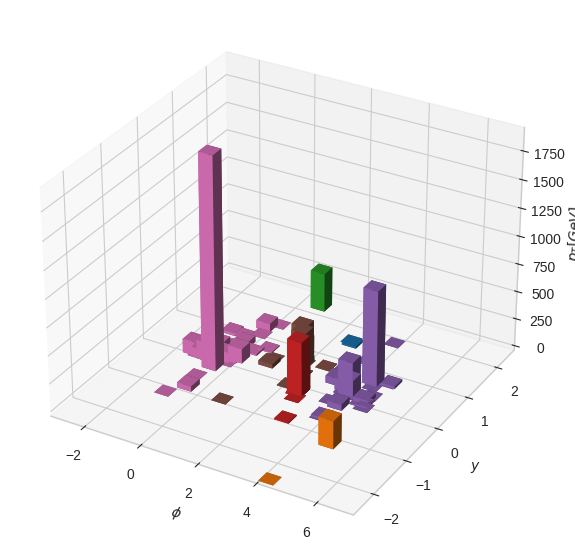

In [31]:
points_cluster0=points_angular[centers_2_7q==0]
points_cluster1=points_angular[centers_2_7q==1]
points_cluster2=points_angular[centers_2_7q==2]
points_cluster3=points_angular[centers_2_7q==3]#changed
points_cluster4=points_angular[centers_2_7q==4]#changed
points_cluster5=points_angular[centers_2_7q==5]
points_cluster6=points_angular[centers_2_7q==6]
#points_cluster7=points_angular[centers_2_7c==7]
#points_cluster8=points_angular[centers_2_7c==8]

fig = plt.figure(figsize=(7,7))
#fig = plt.figure()
ax1 = fig.add_subplot( projection='3d')
ax1.set_ylabel('$y$')
ax1.set_xlabel('$\phi$')
ax1.set_zlabel('$p_T [GeV]$')
ax1.set_ylim([-2.5, 2.5])
ax1.set_xlim([-3, 7])
width =0.5
depth = 0.25
#blue
ax1.bar3d(points_cluster0[:,2], points_cluster0[:,1], np.zeros_like(points_cluster0[:,1]), width, depth, points_cluster0[:,0],shade=True)
#orange
ax1.bar3d(points_cluster1[:,2], points_cluster1[:,1], np.zeros_like(points_cluster1[:,1]), width, depth, points_cluster1[:,0],shade=True)
#green
ax1.bar3d(points_cluster2[:,2], points_cluster2[:,1], np.zeros_like(points_cluster2[:,1]), width, depth, points_cluster2[:,0],shade=True)
#red
ax1.bar3d(points_cluster3[:,2], points_cluster3[:,1], np.zeros_like(points_cluster3[:,1]), width, depth, points_cluster3[:,0],shade=True)
#purple
ax1.bar3d(points_cluster4[:,2], points_cluster4[:,1], np.zeros_like(points_cluster4[:,1]), width, depth, points_cluster4[:,0],shade=True)
#brown
ax1.bar3d(points_cluster5[:,2], points_cluster5[:,1], np.zeros_like(points_cluster5[:,1]), width, depth, points_cluster5[:,0],shade=True)
#pink
ax1.bar3d(points_cluster6[:,2], points_cluster6[:,1], np.zeros_like(points_cluster6[:,1]), width, depth, points_cluster6[:,0],shade=True)
#grey
#ax1.bar3d(points_cluster7[:,2], points_cluster7[:,1], np.zeros_like(points_cluster7[:,1]), width, depth, points_cluster7[:,0],shade=True)
#ocher (behind green)
#ax1.bar3d(points_cluster8[:,2], points_cluster8[:,1], np.zeros_like(points_cluster8[:,1]), width, depth, points_cluster8[:,0],shade=True)


#fig.add_axes(ax)
#ax1.set_title("Classical $k_T$, a=1, R=1")
plt.show()

#saving the plot
image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'quantum_kt_nt2.pdf'
fig.savefig(image_name, format=image_format, dpi=500)

In [32]:
#REAL DATA
a=0
R=1
points_energy=points
points_angular=transform_all_to_angular_4(points_energy)
#QUANTUM
qsearch=True
jets_0_quantum7q=run_kt_inclusive(points_angular,points_energy,a,R,qsearch,10)
final_jets_mom_0_7q=transform_all_to_momentum_4(jets_0_quantum7q[0])
print(final_jets_mom_0_7q)
print(jets_0_quantum7q[3])
print(jets_0_quantum7q[4])
lista_0_7q=list(np.arange(len(points)))
sol_0_7q=jets_0_quantum7q[3]
#print(sol[1].index(13))
for i in range(len(final_jets_mom_0_7q)):
    for j in range(len(sol_0_7q[i])):
        lista_0_7q[sol_0_7q[i][j]]=i
centers_0_7q = np.array(lista_0_7q)    
print(lista_0_7q)


[[ 4.86045730e+01  3.21800500e+01  1.47023430e+01  6.41410850e+01]
 [ 2.99683000e+02  1.81572000e+02  1.30283000e+03  1.34913000e+03]
 [ 8.41301710e+01 -4.90765437e+01  1.14809200e+02  1.55864142e+02]
 [-2.40102569e+02  1.84799140e+03  7.87196752e+02  2.02386088e+03]
 [-1.36756000e+01  1.04563300e+01  2.90168900e+01  3.37473600e+01]
 [-1.12628603e+03 -1.18938086e+03  4.68217565e+02  1.82641355e+03]
 [ 2.18493624e+03 -1.68664754e+03 -8.39971914e+02  3.04926518e+03]
 [-1.22515088e+03  1.10326631e+03 -5.74002952e+02  1.75097740e+03]
 [-1.24095000e+01 -2.50566000e+02 -4.62284000e+02  5.25969000e+02]
 [ 2.75565110e-01  2.05717250e-01 -5.14232100e-01  6.28854500e-01]]
[[35, 53, 44, 62], [32], [15, 49, 50, 56, 54], [9, 96, 97, 112, 119, 115, 120, 127, 98, 101, 106, 103, 116, 104, 122, 109, 111, 125, 99, 100, 107, 118, 102, 108, 117, 110, 124, 105, 123, 114, 121, 126, 113], [41, 43], [0, 23, 59, 10, 27, 8, 63, 24, 16, 28, 2, 12, 4, 19, 31, 11, 26, 14, 20, 7, 29, 39, 46], [3, 13, 5, 45, 18, 21,

In [45]:
effs_cam,centers_0_7q_2=final_efficiency_converged(centers_0_7c,centers_0_7q,max(centers_0_7q)+1)
print(centers_0_7q_2)
print(centers_0_7q)
print(centers_0_7c)
print(effs_cam)

[8 7 8 6 8 6 6 8 8 5 8 8 8 6 8 4 8 3 6 8 8 6 9 8 8 3 8 8 8 8 6 8 2 6 6 1 6
 3 6 8 6 0 6 0 1 6 8 6 9 4 4 6 6 1 4 6 4 6 6 8 3 6 1 8 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[5 8 5 6 5 6 6 5 5 3 5 5 5 6 5 2 5 7 6 5 5 6 9 5 5 7 5 5 5 5 6 5 1 6 6 0 6
 7 6 5 6 4 6 4 0 6 5 6 9 2 2 6 6 0 2 6 2 6 6 5 7 6 0 5 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[8 7 8 6 8 6 6 8 8 5 8 8 8 6 8 4 8 3 6 8 8 6 9 8 8 3 8 8 8 8 6 8 2 6 6 1 6
 3 6 8 6 0 6 0 1 6 8 6 9 4 4 6 6 1 4 6 4 6 6 8 3 6 1 8 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
1.0


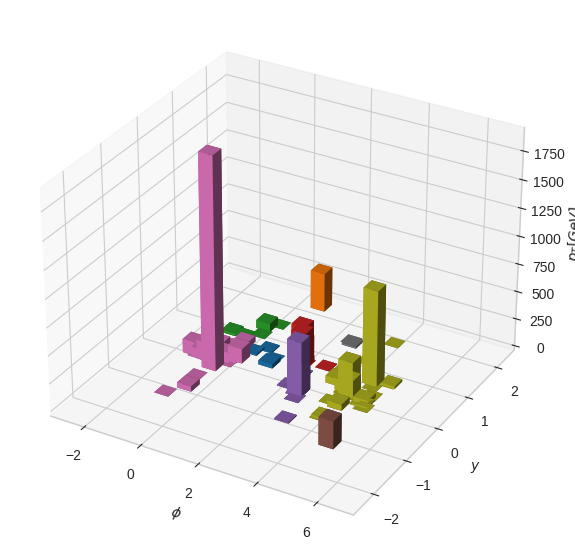

In [34]:
points_cluster0=points_angular[centers_0_7q==0]
points_cluster1=points_angular[centers_0_7q==1]
points_cluster2=points_angular[centers_0_7q==2]
points_cluster3=points_angular[centers_0_7q==3]
points_cluster4=points_angular[centers_0_7q==7]
points_cluster5=points_angular[centers_0_7q==8]#changed
points_cluster6=points_angular[centers_0_7q==6]#changed
points_cluster7=points_angular[centers_0_7q==4]
points_cluster8=points_angular[centers_0_7q==5]

fig = plt.figure(figsize=(7,7))
#fig = plt.figure()
ax1 = fig.add_subplot( projection='3d')
ax1.set_ylabel('$y$')
ax1.set_xlabel('$\phi$')
ax1.set_zlabel('$p_T [GeV]$')
ax1.set_ylim([-2.5, 2.5])
ax1.set_xlim([-3, 7])
width =0.5
depth = 0.25
#blue
ax1.bar3d(points_cluster0[:,2], points_cluster0[:,1], np.zeros_like(points_cluster0[:,1]), width, depth, points_cluster0[:,0],shade=True)
#orange
ax1.bar3d(points_cluster1[:,2], points_cluster1[:,1], np.zeros_like(points_cluster1[:,1]), width, depth, points_cluster1[:,0],shade=True)
#green
ax1.bar3d(points_cluster2[:,2], points_cluster2[:,1], np.zeros_like(points_cluster2[:,1]), width, depth, points_cluster2[:,0],shade=True)
#red
ax1.bar3d(points_cluster3[:,2], points_cluster3[:,1], np.zeros_like(points_cluster3[:,1]), width, depth, points_cluster3[:,0],shade=True)
#purple
ax1.bar3d(points_cluster4[:,2], points_cluster4[:,1], np.zeros_like(points_cluster4[:,1]), width, depth, points_cluster4[:,0],shade=True)
#brown
ax1.bar3d(points_cluster5[:,2], points_cluster5[:,1], np.zeros_like(points_cluster5[:,1]), width, depth, points_cluster5[:,0],shade=True)
#pink
ax1.bar3d(points_cluster6[:,2], points_cluster6[:,1], np.zeros_like(points_cluster6[:,1]), width, depth, points_cluster6[:,0],shade=True)
#grey
ax1.bar3d(points_cluster7[:,2], points_cluster7[:,1], np.zeros_like(points_cluster7[:,1]), width, depth, points_cluster7[:,0],shade=True)
#ocher (behind green)
ax1.bar3d(points_cluster8[:,2], points_cluster8[:,1], np.zeros_like(points_cluster8[:,1]), width, depth, points_cluster8[:,0],shade=True)

#fig.add_axes(ax)
#ax1.set_title("Classical $anti-k_T$, a=-1, R=1")
plt.show()

#saving the plot
#shots=1000
image_format = 'pdf' # e.g .png, .svg, etc.
image_name = 'quantum_cam_nt2.pdf'
fig.savefig(image_name, format=image_format, dpi=500)